In [44]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from plotly import graph_objects as go

import sys
sys.path.append("..")

flatten = lambda t: [item for sublist in t for item in sublist]

In [3]:
comment_df = pd.read_excel("..\data\cleaned_swed_lemma.xlsx")
#comment_df.drop(index = [9, 1555, 2474, 2483, 4346, 7212], inplace = True)

#remove short words
#comment_df.text = comment_df.text.map(lambda line: " ".join( [word for word in line.split(" ") if (len(word) > 3 or word == "mzp")] ))

In [4]:
comment_df

Unnamed: 0  Unnamed: 0.1 comment_id  \
0              0             5    hgikv58   
1              1             6    hgilh98   
2              2             7    hgiledw   
3              3             8    hgilif7   
4              4             9    hgik5u8   
...          ...           ...        ...   
8590        8590         16518    hb5zin0   
8591        8591         16519    hb66gf4   
8592        8592         16520    hb5zm9h   
8593        8593         16521    hb643ll   
8594        8594         16522    hb60btr   

                                                   text         author  \
0                        újranezem Edit elmond vélemény        MarkMew   
1     több hallgat dobrev klárából érez iqval rendel...     just_szabi   
2     tetszik mzp korrupcióellenes javaslat válaszol...     Buntisteve   
3     mzp valós dolog állít kimért óvatos költekezik...       Atekboss   
4     feszült vita hajtépős ideges dobrev lenézően p...      ChronosHD   
...                                                 ...            ...   
8590  sajtó jelenik híre sosem állított megüt bevert...    hadhazyakos   
8591  protip life bírósági ítéleteket maga egész ért...  orbanygyiktor   
8592  hangfelvételen dulakodás hamisítvány szegény S...        BitPork   
8593  schiffer kavar szar rendes „látlelet” garázdas...      dickblaha   
8594                érdekes pont befejeződni hónap pont     Halal0szto   

      upvotes   timestamp post_id  lens  
0           3  1634150485  q7hft0    14  
1           3  1634150728  q7hft0    19  
2           2  1634150698  q7hft0    47  
3           2  1634150741  q7hft0    41  
4           3  1634150198  q7hft0    30  
...       ...         ...     ...   ...  
8590       89  1630486947  pfpjma    65  
8591        7  1630492763  pfpjma    24  
8592       10  1630487037  pfpjma    12  
8593       13  1630490921  pfpjma    85  
8594        4  1630487677  pfpjma    22  

[8589 rows x 9 columns]

# TF-IDF

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer()

In [4]:
term_doc = pd.DataFrame(c.fit_transform(comment_df.text.astype('U')).toarray())
#term_doc = pd.get_dummies(comment_df.text)

term_frequency = term_doc.divide( term_doc.sum(axis="columns"), axis="rows")
term_frequency.sum(axis="columns")

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8584    1.0
8585    1.0
8586    1.0
8587    1.0
8588    1.0
Length: 8589, dtype: float64

In [5]:
# idf number of documents / number of documents containing the word
temp = np.zeros(len(term_doc.columns))

for i in range(len(temp)):
    temp[i] = sum(term_doc.iloc[:,i].map(lambda x: 1 if x > 0 else 0))
    
idf = np.log(len(term_doc) / temp)

In [6]:
tf_idf = term_frequency * idf


In [7]:
#LSA method: making SVD with the tf_idf, then taking the first n most significant vectors to score the documents

from sklearn.decomposition import TruncatedSVD
n_comp = 7
svd = TruncatedSVD(n_components = n_comp)
lsa = svd.fit_transform(tf_idf)

In [8]:
topic_encoded_df = pd.DataFrame(lsa, index = comment_df.index,
                                columns = [f"topic{i}" for i in range(n_comp)])
topic_encoded_df["text"] = comment_df.text

In [9]:
encoding_matrix = pd.DataFrame(svd.components_, 
                               index = [f"topic{i}" for i in range(n_comp)], 
                               columns = c.get_feature_names())


C:\Users\balin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
top_by_topic = pd.DataFrame()
for col in encoding_matrix.index:
    topic_temp_df = pd.DataFrame(encoding_matrix.T.sort_values(col, axis = "rows", ascending = False, 
                                                               key = np.abs)[col][:15]).reset_index()
    topic_temp_df.columns = [col, col+"_value"]
    top_by_topic = pd.concat([top_by_topic, topic_temp_df.round(2)], axis = 1)

In [11]:
top_by_topic.to_excel(r"..\data\top_by_topic_LSI_lemma.xlsx")
top_by_topic

topic0  topic0_value       topic1  topic1_value     topic2  \
0         mzp          0.24     átlépted          0.30  gyurcsány   
1      szavaz          0.23     korlátot          0.30       stop   
2         tud          0.21    végrehajt          0.29  karácsony   
3      dobrev          0.21        poszt          0.29     szavaz   
4         fog          0.20         napi          0.29     online   
5   karácsony          0.19       próbál          0.27        mzp   
6      fidesz          0.18   intézkedés          0.27        tud   
7   gyurcsány          0.16  automatikus          0.26     dobrev   
8        mond          0.14     töröltük          0.26   átlépted   
9        nyer          0.14    posztodat          0.26   korlátot   
10      ember          0.13          bot          0.26      soros   
11      orbán          0.13    gyurcsány         -0.18  végrehajt   
12       akar          0.12    karácsony         -0.12       megy   
13       megy          0.11         stop         -0.11        fog   
14        lát          0.10          mzp         -0.10      poszt   

    topic2_value     topic3  topic3_value     topic4  topic4_value     topic5  \
0           0.60       poll          0.73     dobrev          0.49     szavaz   
1           0.41      peter          0.56        mzp          0.33     online   
2           0.31      tamad          0.15  gyurcsány         -0.32       stop   
3          -0.23      cimbe          0.15       stop         -0.23      csaba   
4          -0.12     tegyel          0.14  karácsony          0.20       tóth   
5           0.11       ujra          0.13        tud         -0.17        fog   
6          -0.11   reportol          0.12      klára          0.16        tud   
7           0.11   vegzetes          0.08       nyer          0.16      orbán   
8           0.10     lecsap          0.08      ember         -0.15   dobrevre   
9           0.10  figyelmes          0.08        fog          0.11        mzp   
10          0.10     ittvan          0.07  visszalép          0.11  karácsony   
11          0.09    templom          0.06       java          0.11       megy   
12         -0.09    peterre          0.05       akar         -0.10   szavazás   
13         -0.09   lefekudt          0.05      jakab          0.10      mzpre   
14          0.09      oszko          0.05        lép          0.10  gyurcsány   

    topic5_value     topic6  topic6_value  
0           0.60     dobrev         -0.40  
1           0.26       tóth          0.39  
2           0.21      csaba          0.38  
3          -0.16  karácsony          0.31  
4          -0.16  gyurcsány         -0.22  
5           0.15        mzp          0.19  
6          -0.15        fog          0.18  
7          -0.14      klára         -0.17  
8           0.13      orbán         -0.16  
9          -0.12       stop          0.14  
10          0.11       nyer         -0.09  
11          0.11      ember         -0.08  
12          0.09    hadházy          0.08  
13          0.09  kihátrált          0.08  
14          0.09        the          0.08

In [12]:
#health check: check which elements are none
comment_df.reset_index().drop(columns = ["index"])[term_frequency.isna().T.any()].index

Int64Index([], dtype='int64')

(1.0, 60.0)

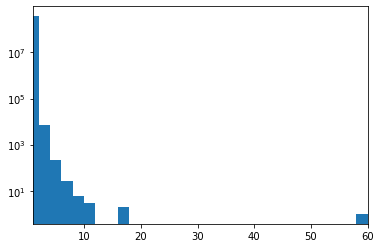

In [13]:
#health check
plt.hist(c.fit_transform(comment_df.text).toarray().flatten(), bins = 30)
plt.yscale("log")
plt.xlim(1,60)

# SKLearn pipeline

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

comment_df = pd.read_csv("..\data\group_40_100.csv")


n_comp = 5
svd2 = TruncatedSVD(n_components = n_comp)

tf_idf_sk = TfidfVectorizer(norm="l1")
X = tf_idf_sk.fit_transform(comment_df.text)

lsa2 = svd2.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa2, columns = [f"topic{i}" for i in range(n_comp)])

encoding_matrix2 = pd.DataFrame(svd2.components_, 
                               index = [f"topic{i}" for i in range(n_comp)], 
                               columns = tf_idf_sk.get_feature_names())

top_by_topic2 = pd.DataFrame()
for col in encoding_matrix2.index:
    topic_temp_df2 = pd.DataFrame(encoding_matrix2.T.sort_values(col, axis = "rows", ascending = False, 
                                                               key = np.abs)[col][:15]).reset_index()
    topic_temp_df2.columns = [col, col+"_value"]
    top_by_topic2 = pd.concat([top_by_topic2, topic_temp_df2], axis = 1)

C:\Users\balin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Generate topics

In [45]:
def lsi_pipeline(gsize, n_comp, stem_or_lemma):
    comment_df = pd.read_csv(f"..\data\{stem_or_lemma}\group_{gsize[0]}_{gsize[1]}.csv")


    svd2 = TruncatedSVD(n_components = n_comp)

    tf_idf_sk = TfidfVectorizer(norm="l1")
    X = tf_idf_sk.fit_transform(comment_df.text)

    svd2.fit_transform(X)

    #topic_encoded_df = pd.DataFrame(lsa2, columns = [f"topic{i}" for i in range(n_comp)])

    encoding_matrix2 = pd.DataFrame(svd2.components_, 
                                index = [f"topic{i}" for i in range(n_comp)], 
                                columns = tf_idf_sk.get_feature_names())

    top_by_topic2 = pd.DataFrame()
    for col in encoding_matrix2.index:
        topic_temp_df2 = pd.DataFrame(encoding_matrix2.T.sort_values(col, axis = "rows", ascending = False, 
                                                                key = np.abs)[col][:30]).reset_index()
        topic_temp_df2.columns = [col, col+"_value"]
        top_by_topic2 = pd.concat([top_by_topic2, topic_temp_df2], axis = 1)

    return top_by_topic2

In [46]:
lsi_pipeline((40,60), 5, "stem")

topic0  topic0_value        topic1  topic1_value  \
0                dobrev      0.998097           mzp     -0.247174   
1                   mzp      0.017125        fidesz     -0.194743   
2             karácsony      0.014354       ellenze     -0.188730   
3                 jakab      0.013881     karácsony     -0.175066   
4                    dk      0.011259       szavazn     -0.171029   
5               szavazó      0.010298         ember     -0.143911   
6                fidesz      0.010151       szavazó     -0.142511   
7               szavazn      0.010121     választás     -0.140910   
8                 esély      0.010020         jelöl     -0.136220   
9              márkizay      0.009374            dk     -0.129426   
10              ellenze      0.009231        jelölt     -0.127233   
11                jelöl      0.008924          jobb     -0.109550   
12                 nyer      0.008318     gyurcsány     -0.102538   
13              forduló      0.007542          párt     -0.101773   
14              kariger      0.007357          akar     -0.100943   
15                 jobb      0.006241        kérdés     -0.099926   
16                ember      0.005869       kormány     -0.097086   
17            választás      0.005759         jakab     -0.095849   
18               biztos      0.005541       forduló     -0.092089   
19               szavaz      0.005319         esély     -0.090808   
20            gyurcsány      0.004805        ország     -0.090246   
21               kérdés      0.004788        biztos     -0.089246   
22                 akar      0.004768  előválasztás     -0.085613   
23          visszalépés      0.004729        szavaz     -0.085531   
24               jelölt      0.004703      rendszer     -0.082590   
25              kormány      0.004611          rész     -0.081414   
26               győzel      0.004489          anny     -0.079931   
27                 párt      0.004425          nyer     -0.079515   
28  miniszterelnökjelöl      0.004381    összefogás     -0.077666   
29         előválasztás      0.004313          megy     -0.075598   

             topic2  topic2_value               topic3  topic3_value  \
0           százale      0.236664            karácsony     -0.392234   
1   választókerület      0.228743                  mzp     -0.340696   
2            jelölt      0.218010           alapítvány      0.179312   
3             sátor      0.215674                jakab     -0.142547   
4           szavazn      0.197875        finanszírozás      0.126768   
5            körzet      0.163160              ellenze      0.126188   
6             onlin      0.149862            választás      0.125108   
7              voks      0.135079              egyetem      0.122875   
8             ember     -0.134943      választókerület      0.111444   
9             egyén      0.133071              szavazó     -0.107957   
10          kormány     -0.131203                egyén      0.107912   
11            jelöl      0.119678             márkizay     -0.104585   
12            számú      0.117881                sátor      0.104163   
13           ország     -0.115722               fidesz      0.102890   
14          bármely      0.112814              kormány      0.102826   
15           szavaz      0.111697               jelölt      0.093327   
16         szavazat      0.108528             rendszer      0.092165   
17          forduló      0.105936              forduló     -0.086182   
18          szavazó      0.104405              kariger     -0.084216   
19        gyurcsány     -0.104154               körzet      0.082127   
20             akar     -0.097132               fegyőr     -0.077344   
21           magyar     -0.097124          visszalépés     -0.073695   
22          ellenze      0.093666              törvény      0.072311   
23       alapítvány     -0.084663               listás      0.071285   
24             megy      0.083939              oktatás      0.071050   
25   

In [55]:
groupings = [ (7,10), (10,20), (20,40), (40,60), (60,100), (15,40), (40,100)]
n_comps = [6, 10, 15, 20]
stem_or_lemma = "stem"


for gsize in groupings:
    writer = pd.ExcelWriter(fr'..\out\lsi_{gsize}_{stem_or_lemma}.xlsx', engine='xlsxwriter')
    
    
    for n_comp in n_comps:
        df = lsi_pipeline(gsize, n_comp, stem_or_lemma)
        df.to_excel(writer, sheet_name = f"ncomp_{n_comp}" )
    
    writer.save()


In [33]:
encoding_matrix2

30     abbol     ablak      able  abnormális  abortusz  \
topic0  0.000011  0.000464  0.000041  0.000002    0.000025  0.000047   
topic1  0.001345  0.001145  0.004968  0.000175    0.002827  0.005574   
topic2 -0.002934 -0.000470 -0.000652 -0.000376   -0.003727 -0.000153   
topic3  0.000953  0.000069 -0.005064 -0.000292   -0.001085 -0.002412   
topic4  0.001063 -0.000605  0.015079 -0.000832    0.001385  0.013795   

           about  abszolut  abszolút   abszurd  acceptance  accordot  \
topic0  0.000003  0.000682  0.001156  0.000034    0.000003  0.000004   
topic1  0.000248  0.001975  0.019976  0.003724    0.000195  0.000694   
topic2  0.001664 -0.004672 -0.004788 -0.003144    0.001881 -0.002756   
topic3  0.000849  0.002468 -0.004046 -0.001473   -0.000370 -0.004035   
topic4  0.001480 -0.001120  0.014095 -0.006016    0.000007  0.000752   

          accountant   accountants  accountodon  accountok    action  \
topic0  8.871754e-07  4.435877e-07     0.000003   0.000351  0.000003   
topic1  1.302536e-04  6.512679e-05     0.000510   0.002988  0.000195   
topic2 -4.499193e-04 -2.249596e-04    -0.000929   0.000718  0.001881   
topic3  1.385759e-03  6.928795e-04    -0.000021   0.003273 -0.000370   
topic4  5.391834e-05  2.695917e-05     0.000251  -0.000456  0.000007   

            adag  adakoznak  adaléknak     adasa      adat    adatai  \
topic0  0.000008   0.000009   0.000013  0.000003  0.001585  0.000017   
topic1  0.001027   0.001085   0.001791  0.000364  0.021636  0.001595   
topic2 -0.000692  -0.000712  -0.004744 -0.000444  0.012295 -0.000424   
topic3 -0.000709  -0.001633  -0.003488 -0.000265  0.028972  0.002804   
topic4  0.001746   0.000909   0.000733  0.000506  0.031671  0.001376   

        adatbazissal  adatbázis  adatbáziskból  adategyeztetes  \
topic0      0.000004   0.000041       0.000014        0.000004   
topic1      0.000534   0.004596       0.001541        0.000534   
topic2     -0.001009  -0.000239      -0.001112       -0.001009   
topic3      0.000269   0.000077       0.000228        0.000269   
topic4      0.000663   0.004673       0.001305        0.000663   

        adatgyűjtésnek    adatik  adatokból    adatom    adatot    adatsz  \
topic0        0.000418  0.000020   0.000004  0.000026  0.000055  0.000004   
topic1        0.002114  0.002495   0.000441  0.002322  0.005526  0.000513   
topic2        0.006395 -0.001674  -0.000173 -0.000097  0.011346 -0.000346   
topic3       -0.000352 -0.010919  -0.000586  0.004478 -0.000731 -0.000355   
topic4       -0.002396  0.004725  -0.000608  0.004275  0.004063  0.000873   

         adattak   addigra     adieu    adipiscing     adjam  adjunktus  \
topic0  0.000004  0.000034  0.001279  8.626672e-07  0.000026   0.000027   
topic1  0.000527  0.003482  0.003921  1.076656e-04  0.002322   0.003026   
topic2 -0.000963 -0.002444  0.013217  2.682668e-04 -0.000097  -0.003150   
topic3 -0.000654 -0.000219  0.002998  9.249095e-05  0.004478  -0.006151   
topic4  0.001124  0.001172  0.006537  9.387870e-04  0.004275   0.003226   

        adminisztracios  adminisztrációs     adnae   adnának     adnék  \
topic0         0.000004         0.000006  0.000018  0.000014  0.000018   
topic1         0.000534         0.000691  0.002186  0.001638  0.002196   
topic2        -0.001009        -0.000606 -0.000816 -0.003058 -0.000226   
topic3         0.000269        -0.000063 -0.003526  0.001425 -0.004868   
topic4         0.000663         0.000829 -0.000115  0.000739  0.004334   

        adokkapok   adomány  adopolitikai  adossagaval  adossága      adot  \
topic0   0.000016  0.000013      0.000003     0.000023  0.000019  0.000008   
topic1   0.001650  0.001519      0.000347     0.002490  0.001793  0.001070   
topic2   0.002253 -0.001784     -0.000385    -0.000468 -0.000474 -0.001959   
topic3  -0.000433 -0.000198     -0.000853    -0.002950 -0.000739 -0.003826   
topic4   0.000279  0.001322      0.001818     0.003086 -0.001323  0.000031   

        adoteher      adoterhe  adovisszateritest      ad